In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Kaggle Workshops Starter Notebook [Python version]
## Online Retail Store: Predicting Visitor Behaviour 

<table align="left">
  <td>
    <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Online%20Retail%20Store%3A%20Predicting%20Visitor%20Behaviour%20-%20Starter%20Notebook%20%5BPython%5D&download_url=https%3A%2F%2Fstorage.googleapis.com%2Fstarter_notebooks%2Fgoogle_analytics_sample_bqml_python.ipynb&url=https%3A%2F%2Fgist.github.com%2Fpolong-lin%2F51bb01bac82513294e10fb9856c4fdb0">
      <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="AI Platform Notebooks">Run on AI Platform Notebooks</a>
  </td>
</table>

- [Setup BigQuery in Jupyter](#setup)
- [BigQuery ML basics](#basics)
  - [Select BigQuery data from Python](#select)
  - [Train a BigQuery ML model](#train)
  - [Check models currently being trained on BigQuery](#currentlytraining)
  - [Check if a model has finished training](#finishedtraining)
  - [Evaluate a BigQuery ML model](#evaluate)
  - [Compare multiple models](#compare)
  - [ML.FEATURE_INFO to check input feature information](#featinfo)
  - [Make predictions using BigQuery ML](#predictions)
  - [Export predictions as a CSV file](#exportcsv)
- [Feature engineering](#feateng)
  - [EXTRACT: Extract dates and time](#extractdates)
  - [REGEXP_EXTRACT_ALL: Extract words from a STRING column](#extractwords)
  - [ML.QUANTILE_BUCKETIZE: Bucketize your numeric feature into bins](#bucketize)
  - [ML.POLYNOMIAL_EXPAND: Combine numeric features](#polynomialexpand)
  - [ML.FEATURE_CROSS: Combine categorical features](#featurecross)
- [Feature selection](#featselection)
  - [ML.FEATURE_IMPORTANCE for Boosted Tree models](#featimportance)

<a id="setup"></a>

### Setup BigQuery in Jupyter 

#### Set parameters

In [39]:
#Check current GCP project ID
# !gcloud config get-value project

In [1]:
PROJECT_ID = "globohack-kaggle21-6923" #REPLACE with project ID
DATASET_ID = "bqmlretail"
LOCATION = "EU"

#### Create dataset if it does not yet exist

In [4]:
!bq mk --location=$LOCATION $DATASET_ID

Dataset 'globohack-kaggle21-6923:bqmlretail' successfully created.


#### Required libraries

In [89]:
#!pip install google-cloud-bigquery --upgrade --quiet
# !pip install pandas-profiling
#!pip install pycountry-convert

In [202]:
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Construct a BigQuery client object.
client = bigquery.Client()

def bq_query(sql, async_flag=False):
    """
    If `async_flag` set to False (default), 
        returns the query results for `sql` as a Pandas DataFrame, 
    Else, submits query asynchronously and returns nothing.
    """
    
    # Try dry run before executing query to catch any errors
    try:
        job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
        dry_run_job = client.query(sql, job_config=job_config)
    except BadRequest as err:
        print(err)
        return
        
    job_config = bigquery.QueryJobConfig()
    df = client.query(sql, job_config=job_config)
    
    if async_flag:
        return f"Query sent asynchronously for job id: {df.job_id}"
    else:
        df = df.result() #wait for query to finish running
        return df.to_dataframe()
    
def pandas_to_bq(df, tablename):
    return client.load_table_from_dataframe(
        dataframe = df, 
        destination = DATASET_ID + '.' + tablename,
        project = PROJECT_ID
    )
    

print("Done.")

Done.


<a id="basics"></a>

## BigQuery ML basics

<a id="select"></a>

#### Select BigQuery data from Python

In [173]:
sql_select = """
WITH
train AS (
    SELECT 
      t.* EXCEPT (totalHits, totalVisits, date, isMobile, browser, city, trafficSource, trafficMedium, trafficCampaign, operatingSystem), 
      CAST(isMobile AS INT64) AS isMobile,
      SIN(2 * ACOS(-1) * EXTRACT(HOUR FROM TIMESTAMP_MILLIS(visitStartTime*1000)) / 24) AS hour,
      SIN(2 * ACOS(-1) * (EXTRACT(DAY FROM TIMESTAMP_MILLIS(visitStartTime*1000))-1) / 30) AS day,
      SIN(2 * ACOS(-1) * (EXTRACT(MONTH FROM TIMESTAMP_MILLIS(visitStartTime*1000))-1) / 11) AS month,
      IF (EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) IN (1,7), 1, 0) AS isWeekend,
      IF (operatingSystem IN ('Macintosh', 'iOS'), 1, 0) AS isApple,
      LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC) AS lastVisitTime,
      CASE
        WHEN TIMESTAMP_DIFF(TIMESTAMP_MILLIS(visitStartTime), TIMESTAMP_MILLIS(LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC)), HOUR) <= 24 THEN 1
        ELSE 0
      END AS hasRecentVisit
    FROM
      kaggleworkshops.google_analytics_sample_eu.train t
    WHERE date BETWEEN TIMESTAMP("2016-01-01")
      AND TIMESTAMP("2016-12-31")
)
SELECT * EXCEPT (visitStartTime, lastVisitTime)
FROM train
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(visitStartTime AS STRING))), 100) <= 60
"""

df = bq_query(sql = sql_select).set_index('fullVisitorId')

df.tail()

,deviceCategory,country,isFirstVisit,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart,isMobile,hour,day,month,isWeekend,isApple,hasRecentVisit
fullVisitorId,,,,,,,,,,,,,,
999150862738363524,mobile,United States,1,1,0,0,0,1,-0.866025,-0.587785,-9.898214e-01,0,0,0
9994595199466781769,desktop,United States,0,2,341,0,0,0,-0.500000,0.587785,-1.133108e-15,1,1,1
9994595199466781769,desktop,United States,0,2,291,0,0,0,-0.965926,0.587785,-1.133108e-15,1,1,1
9994595199466781769,desktop,United States,0,1,0,0,0,0,-0.500000,0.994522,-1.133108e-15,0,1,1
9994595199466781769,desktop,United States,0,1,0,0,0,0,0.866025,0.994522,-1.133108e-15,0,1,1


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262006 entries, 0 to 262005
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorId       262006 non-null  object 
 1   deviceCategory      262006 non-null  object 
 2   operatingSystem     262006 non-null  object 
 3   country             262006 non-null  object 
 4   trafficSource       262006 non-null  object 
 5   trafficMedium       262006 non-null  object 
 6   trafficCampaign     262006 non-null  object 
 7   isFirstVisit        262006 non-null  int64  
 8   totalPageviews      262006 non-null  int64  
 9   totalTimeOnSite     262006 non-null  int64  
 10  productPagesViewed  262006 non-null  int64  
 11  addedToCart         262006 non-null  int64  
 12  isMobile            262006 non-null  int64  
 13  hour                262006 non-null  float64
 14  day                 262006 non-null  float64
 15  month               262006 non-nul

### Exploratory Data Analysis

In [90]:
# %%time
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile

<AxesSubplot:>

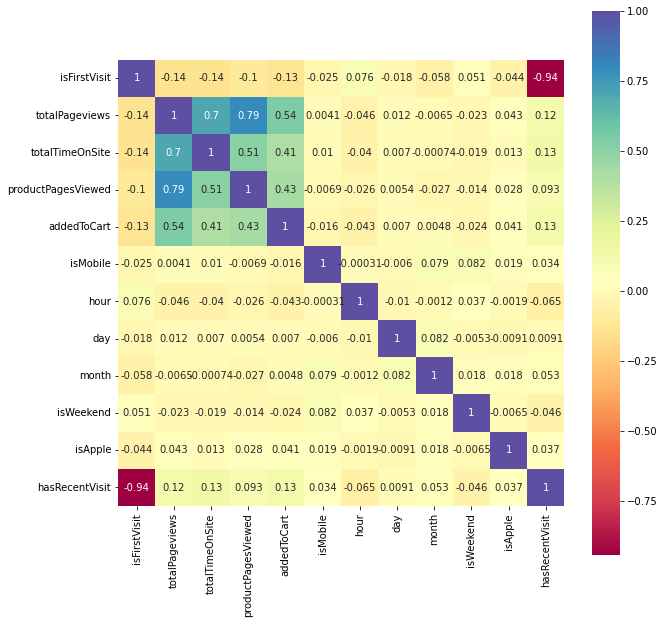

In [174]:
corr_matrix = df.corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, cbar=True, annot=True, cmap='Spectral')

<BarContainer object of 2 artists>

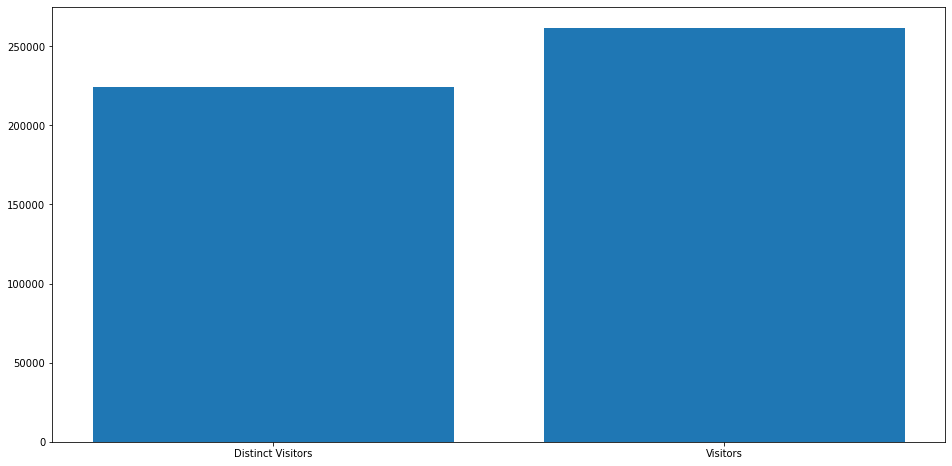

In [120]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(['Distinct Visitors', 'Visitors'], [df.fullVisitorId.nunique(), df.shape[0]])

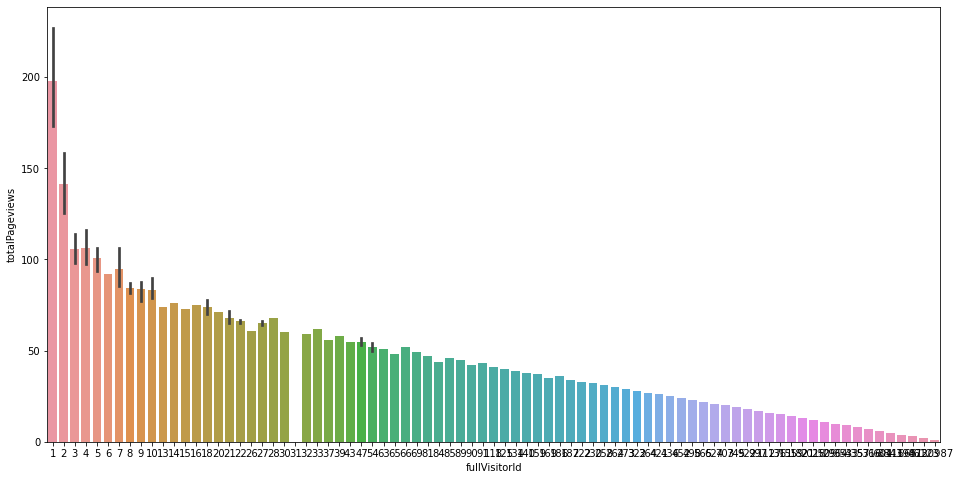

In [148]:
def plot_categorical_variable(column: str, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    df_plot = pd.DataFrame(df.groupby(column)['fullVisitorId'].count()).reset_index(drop=False)
    sns.barplot(data=df_plot, x="fullVisitorId", y=column, ax=ax)
    fig.savefig(f'./plots/{column}.jpeg', bbox_inches='tight')
    
column = 'totalPageviews'
plot_categorical_variable(column)

In [123]:
@np.vectorize
def binarize_time_on_site(time, threshold=5):
    return 1 if time > 5 else 0

@np.vectorize
def binarize_product_pages_viewed(pv):
    if pv <= 1:
        return 1
    elif pv > 1 and pv <= 3:
        return 2
    elif pv > 3:
        return 5
    return 0


@np.vectorize
def get_continent_code(country): 
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")

        return pc.country_alpha2_to_continent_code(country_code)
    except:
        return 'Other'

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


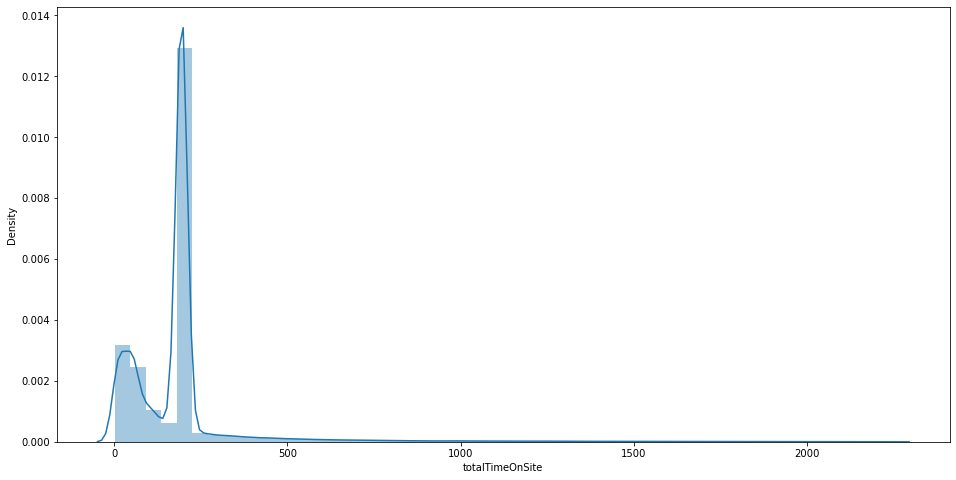

In [169]:
def plot_numerical_variable(column:str, figsize=(16,8), log=False, max_value=None):
    fig, ax = plt.subplots(figsize=figsize)
    df_plot = df.copy()
    if max_value:
        df_plot = df_plot.query(f'{column} <= {max_value}')
    
    if log:
        sns.distplot(np.log(1+df_plot[column]), ax=ax)
    else:
        sns.distplot(df_plot[column], ax=ax)
    
plot_numerical_variable('totalTimeOnSite', log=False, max_value = None)

In [175]:
df = df[df.totalTimeOnSite <= df.query('totalTimeOnSite > 0')['totalTimeOnSite'].quantile(q=.99)]
df = df[df.totalPageviews <= df.query('totalPageviews > 0')['totalPageviews'].quantile(q=.99)]
df = df[df.productPagesViewed <= df.query('productPagesViewed > 0')['productPagesViewed'].quantile(q=.99)]

for column in ['totalTimeOnSite', 'totalPageviews', 'productPagesViewed']:
    df.loc[ df[df[column] == 0].index, column ] = df.query(column + ' > 0')[column].mean()

## Preprocessing

### Categorical
- `deviceCategory`: oneHotEncoding
- `isMobile`: cast to integer
- `browser`: ignored (device category is enough)
- `country`: get_continent_code and oneHotEncoding
- `city`: ignored
- `trafficSource`: ignored (?)
- `trafficMedium`: ignored (?)
- `trafficCampaign`: ignored (?)
- `operatingSystem`: binarize_os_category

### Numerical
- `isFirstVisit`: leave as is
- `totalVisits`: ignored
- `totalPageviews`: log (but we could binarize as well (like light/medium/heavy user)
* - `totalTimeOnSite`: substituir nulos por mediana dos não-nulos # threshold on 5
- `productPagesViewed`: binarize_product_pages_viewed
- `addedToCart`
- `hour`: get_cyclic_hour
- `day`: get_cyclic_day
- `month`: get_cyclic_month
- `isWeekend`: leave as is


In [177]:
df['totalPageviews'] = np.log(1+df['totalPageviews'])
df['country'] = df['country'].apply(get_continent_code)

In [83]:
def get_relation(data: pd.DataFrame(), col: str):
    relation_df = pd.DataFrame(data\
        .groupby(by=[col, 'addedToCart'])\
        .count()['fullVisitorId']).reset_index()\
        .pivot(index=col, columns='addedToCart', values='fullVisitorId')
    relation_df['percent'] = relation_df[1] / (relation_df[0]+relation_df[1])
    return relation_df

get_relation(df, 'trafficMedium')

addedToCart,0,1,percent
trafficMedium,,,
(none),16058.0,2742.0,0.145851
(not set),2.0,NaN,NaN
affiliate,1752.0,157.0,0.082242
cpc,1331.0,136.0,0.092706
cpm,394.0,55.0,0.122494
organic,22121.0,2022.0,0.083751
referral,27669.0,320.0,0.011433


<a id="train"></a>

Saving pre-processed dataframe to BigQuery

In [ ]:
pandas_to_bq(df.reset_index(drop=True))

#### Train a BigQuery ML model

- [Hyperparameter Tunning](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#hparam_tuning_algorithm)

In [264]:
model_name = 'logistic_reg'

sql_logreg_sample = f"""
CREATE OR REPLACE MODEL bqmlretail.{model_name}
TRANSFORM("""

sql_logreg_sample += ', '.join(df.columns)
  
sql_logreg_sample += f"""
)
OPTIONS(
  model_type='{model_name}', 
  INPUT_LABEL_COLS=["addedToCart"],
  num_trials=100,
  HPARAM_TUNING_ALGORITHM = 'VIZIER_DEFAULT',
  HPARAM_TUNING_OBJECTIVES = ['ROC_AUC'],
  DATA_SPLIT_METHOD = 'RANDOM', 
  l1_reg = HPARAM_RANGE(0, 10),
  l2_reg = HPARAM_RANGE(0, 10)
) AS
SELECT 
  *
FROM
  `{PROJECT_ID}.{DATASET_ID}.train_processed`
"""

#send asynchronously
bq_query(sql = sql_logreg_sample, async_flag=True)

'Query sent asynchronously for job id: f6717798-1671-4309-9b6a-57fd0089ea49'

In [263]:
model_name = 'boosted_tree_classifier'

sql_logreg_sample = f"""
CREATE OR REPLACE MODEL bqmlretail.{model_name}
TRANSFORM("""

sql_logreg_sample += ', '.join(df.columns)
  
sql_logreg_sample += f"""
)
OPTIONS(
  model_type='{model_name}', 
  INPUT_LABEL_COLS=["addedToCart"],
  num_trials=100,
  HPARAM_TUNING_ALGORITHM = 'VIZIER_DEFAULT',
  HPARAM_TUNING_OBJECTIVES = ['ROC_AUC'],
  DATA_SPLIT_METHOD = 'RANDOM', 
  learn_rate = HPARAM_RANGE(0.0001, 0.1),
  l2_reg = HPARAM_RANGE(0, 10),
  dropout = HPARAM_RANGE(0, 1),
  max_tree_depth = HPARAM_RANGE(1, 10),
  subsample = HPARAM_RANGE(0, 1),
  num_parallel_tree=10
) AS
SELECT 
  *
FROM
  `{PROJECT_ID}.{DATASET_ID}.train_processed`
"""

#send asynchronously
bq_query(sql = sql_logreg_sample, async_flag=True)

'Query sent asynchronously for job id: 3e3a64fc-5065-4560-8c74-5ef2ced7d27c'

Other model types for classification:
 - [`logistic_reg`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create)
 - [`boosted_tree_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)
 - [`dnn_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models)
 - [`automl_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl)

<a id="currentlytraining"></a>

#### Check models currently being trained on BigQuery

This will check if the models in your project are still undergoing training.

In [268]:
sql_currentlyrunningqueries = f"""
SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'{DATASET_ID}\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){{0,1}}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state != "DONE"
"""

print(sql_currentlyrunningqueries)

#send asynchronously
models_still_training = bq_query(sql_currentlyrunningqueries)

print(f"{len(models_still_training)} models still currently training:")
models_still_training


SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'bqmlretail\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){0,1}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state != "DONE"

2 models still currently training:


,job_id,creation_time,query,modelname
0,f6717798-1671-4309-9b6a-57fd0089ea49,2021-11-09 20:18:34.901000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.logistic_reg\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day, month, is...",bqmlretail.logistic_reg
1,3e3a64fc-5065-4560-8c74-5ef2ced7d27c,2021-11-09 20:16:54.937000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day...",bqmlretail.boosted_tree_classifier


<a id="finishedtraining"></a>

#### Check which models have finished training

In [260]:
sql_finished_queries = f"""
SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'{DATASET_ID}\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){{0,1}}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state = "DONE"
ORDER BY creation_time DESC
"""

print(sql_finished_queries)

finished_models = bq_query(sql_finished_queries)
finished_models.head()


SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'bqmlretail\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){0,1}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state = "DONE"
ORDER BY creation_time DESC



,job_id,creation_time,query,modelname
0,0d5d836d-2b6a-4f59-8486-3f6704a22b11,2021-11-09 20:00:48.286000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day...",bqmlretail.boosted_tree_classifier
1,83529ea6-67ed-4595-8e25-ab2d78b4ff6c,2021-11-09 19:56:25.856000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day...",bqmlretail.boosted_tree_classifier
2,ff8e7076-3ddf-4e1b-979c-d965182db95d,2021-11-09 18:22:34.417000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.dnn_classifier\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day, month, ...",bqmlretail.dnn_classifier
3,708cf365-e8a8-4fda-9b10-ba02b9a70e4f,2021-11-09 18:08:21.587000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day...",bqmlretail.boosted_tree_classifier
4,5c0f570c-5461-42fe-ac86-4190b4669ea3,2021-11-09 14:22:11.379000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.logreg_sample\nTRANSFORM(deviceCategory, country, isFirstVisit, totalPageviews, totalTimeOnSite, productPagesViewed, addedToCart, isMobile, hour, day, month, i...",bqmlretail.logreg_sample


<a id="evaluate"></a>

#### Evaluate a BigQuery ML model

In [261]:
MODEL_NAME = "boosted_tree_classifier"

sql_logreg_sample = f"""
SELECT 
  *
FROM
  ML.EVALUATE(
      MODEL {DATASET_ID}.{MODEL_NAME})
"""

print(sql_logreg_sample)

bq_query(sql = sql_logreg_sample)


SELECT 
  *
FROM
  ML.EVALUATE(
      MODEL bqmlretail.boosted_tree_classifier)



,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.636364,0.219731,0.959972,0.326667,0.095016,0.959202


<a id="compare"></a>

### Compare multiple models

In [240]:
MODEL_LIST = ["boosted_tree_classifier", "logreg_sample", "dnn_classifier"
              ] #change or add models here

sql_modeleval_list = [f"SELECT \n  '{modelname}' as modelname, \n  * \nFROM \n  ML.EVALUATE(MODEL {DATASET_ID}.{modelname})"
                      for modelname 
                      in MODEL_LIST]

sql_compare_evaluation = "\n\nUNION ALL\n\n".join(sql_modeleval_list)

print(sql_compare_evaluation)

bq_query(sql_compare_evaluation)

SELECT 
  'boosted_tree_classifier' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.boosted_tree_classifier)

UNION ALL

SELECT 
  'logreg_sample' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logreg_sample)

UNION ALL

SELECT 
  'dnn_classifier' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.dnn_classifier)


,modelname,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,boosted_tree_classifier,0.636364,0.219731,0.959972,0.326667,0.095016,0.959202
1,logreg_sample,0.653333,0.109865,0.958090,0.188100,0.109639,0.942639
2,dnn_classifier,0.593750,0.255605,0.959378,0.357367,0.099214,0.951996


<a id="featinfo"></a>

### ML.FEATURE_INFO to check input feature information

The ML.FEATURE_INFO function allows you to see information about the input features used to train a model. [ML.FEATURE_INFO Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [241]:
MODEL_NAME = "dnn_classifier"

sql_featureinfo = f"""
SELECT
    *
FROM
    ML.FEATURE_INFO(MODEL bqmlretail.{MODEL_NAME})
"""

bq_query(sql_featureinfo)

,input,min,max,mean,median,stddev,category_count,null_count
0,country,NaN,NaN,NaN,NaN,NaN,7.0,0
1,day,-0.994522,0.994522,0.003948,0.000000,0.695927,NaN,0
2,deviceCategory,NaN,NaN,NaN,NaN,NaN,3.0,0
3,hasRecentVisit,0.000000,1.000000,0.182979,0.000000,0.386650,NaN,0
4,hour,-1.000000,1.000000,-0.115703,-0.258819,0.710573,NaN,0
5,isApple,0.000000,1.000000,0.421380,0.000000,0.493781,NaN,0
6,isFirstVisit,0.000000,1.000000,0.801361,1.000000,0.398977,NaN,0
7,isMobile,0.000000,1.000000,0.200051,0.000000,0.400039,NaN,0
8,isWeekend,0.000000,1.000000,0.222531,0.000000,0.415946,NaN,0
9,month,-0.989821,0.000000,-0.632297,-0.755750,0.341302,NaN,0


<a id="predictions"></a>

### Make predictions using BigQuery ML

In [200]:
sql_select = """
WITH
test AS (
    SELECT 
      CONCAT(fullVisitorId, CAST(visitStartTime as string)) as sessionId, 
      t.* EXCEPT (totalHits, totalVisits, date, isMobile, browser, city, trafficSource, trafficMedium, trafficCampaign, operatingSystem), 
      CAST(isMobile AS INT64) AS isMobile,
      SIN(2 * ACOS(-1) * EXTRACT(HOUR FROM TIMESTAMP_MILLIS(visitStartTime*1000)) / 24) AS hour,
      SIN(2 * ACOS(-1) * (EXTRACT(DAY FROM TIMESTAMP_MILLIS(visitStartTime*1000))-1) / 30) AS day,
      SIN(2 * ACOS(-1) * (EXTRACT(MONTH FROM TIMESTAMP_MILLIS(visitStartTime*1000))-1) / 11) AS month,
      IF (EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) IN (1,7), 1, 0) AS isWeekend,
      IF (operatingSystem IN ('Macintosh', 'iOS'), 1, 0) AS isApple,
      LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC) AS lastVisitTime,
      CASE
        WHEN TIMESTAMP_DIFF(TIMESTAMP_MILLIS(visitStartTime), TIMESTAMP_MILLIS(LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC)), HOUR) <= 24 THEN 1
        ELSE 0
      END AS hasRecentVisit
    FROM
      kaggleworkshops.google_analytics_sample_eu.test t
)
SELECT * EXCEPT (visitStartTime, lastVisitTime, fullVisitorId)
FROM test
"""

df_test = bq_query(sql = sql_select)

df_test.tail()

,sessionId,deviceCategory,country,isFirstVisit,totalPageviews,totalTimeOnSite,productPagesViewed,isMobile,hour,day,month,isWeekend,isApple,hasRecentVisit
137941,99581539534067981331501457211,mobile,United States,1,1,0,0,1,-0.258819,-0.207912,-0.281733,1,1,0
137942,99598360862560373711498127338,desktop,Germany,1,1,0,0,0,0.500000,-0.951057,0.281733,0,1,0
137943,99598675226915444041498138256,desktop,Germany,1,1,0,0,0,-0.258819,-0.951057,0.281733,0,0,0
137944,99694392078211575461497551799,desktop,United States,1,1,0,0,0,-1.000000,0.207912,0.281733,0,1,0
137945,99957279867626653731499545920,mobile,United States,1,7,80,0,1,-0.866025,0.994522,-0.281733,1,1,0


In [201]:
df_test['totalPageviews'] = np.log(1+df_test['totalPageviews'])
df_test['country'] = df_test['country'].apply(get_continent_code)

In [203]:
pandas_to_bq(df_test, tablename='test_processed')

LoadJob<project=globohack-kaggle21-6923, location=EU, id=d18db365-a748-42c8-a7da-c6c14b5090f2>

In [242]:
MODEL_NAME = "dnn_classifier"

sql_predict = f"""
SELECT
  sessionId, 
  prob as addedToCart
FROM
  ML.PREDICT(MODEL {DATASET_ID}.{MODEL_NAME},
    (
    SELECT 
      *
    FROM
    `{PROJECT_ID}.{DATASET_ID}.test_processed`
  )),
UNNEST(predicted_addedToCart_probs)
WHERE label = 1
"""

print(sql_predict)

submission = bq_query(sql_predict)
submission.head()


SELECT
  sessionId, 
  prob as addedToCart
FROM
  ML.PREDICT(MODEL bqmlretail.dnn_classifier,
    (
    SELECT 
      *
    FROM
    `globohack-kaggle21-6923.bqmlretail.test_processed`
  )),
UNNEST(predicted_addedToCart_probs)
WHERE label = 1



,sessionId,addedToCart
0,57620979614862299831500851464,0.002304
1,05791299549566660861497856272,0.001900
2,14593605395351717551499791566,0.003367
3,22960310742577551851499504677,0.000230
4,44679779041561447891499058658,0.003320


<a id="exportcsv"></a>

### Export predictions for Kaggle as a CSV file

In [243]:
MODEL_NAME = "dnn_classifier_preprocessed"

#save as CSV
submission.to_csv(f"submission_{MODEL_NAME}.csv", index=False)

The predictions are now saved to a CSV file. To download the file to your computer, locate your file in the left-menu in JupyterLab, right-click on it and click "Download". You can now make a submission to the Kaggle competition with the file.

<hr><a id="feateng"></a>

## Preprocessing Functions in BigQuery ML
You can use [TRANSFORM()](https://cloud.google.com/bigquery-ml/docs/bigqueryml-transform) with any of the [preprocessing functions](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) below.

<a id="extractdates"></a>

#### EXTRACT: Extract dates and time

[EXTRACT from DATE documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)  
[EXTRACT from TIMESTAMP documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/timestamp_functions#extract)

In [10]:
sql_datetime = """
    SELECT
        date,
        EXTRACT( month FROM date) as month,
        EXTRACT( dayofweek FROM date) AS dayofweek,
        EXTRACT( day FROM date) as day,
        
        visitStartTime,
        EXTRACT( hour FROM TIMESTAMP_SECONDS(visitStartTime) ) as hour
    FROM
        kaggleworkshops.google_analytics_sample_eu.train
    LIMIT 10
    """

bq_query(sql_datetime, 
         async_flag = False)

,date,month,dayofweek,day,visitStartTime,hour
0,2016-10-14 00:00:00+00:00,10,6,14,1476492957,0
1,2017-04-30 00:00:00+00:00,4,1,30,1493611205,4
2,2017-03-20 00:00:00+00:00,3,2,20,1490071147,4
3,2017-04-01 00:00:00+00:00,4,7,1,1491048053,12
4,2017-05-20 00:00:00+00:00,5,7,20,1495292376,14
5,2017-05-14 00:00:00+00:00,5,1,14,1494792010,20
6,2017-05-17 00:00:00+00:00,5,4,17,1495047452,18
7,2017-05-15 00:00:00+00:00,5,2,15,1494883945,21
8,2016-10-11 00:00:00+00:00,10,3,11,1476231674,0
9,2016-10-10 00:00:00+00:00,10,2,10,1476144607,0


<a id="extractwords"></a>

#### REGEXP_EXTRACT_ALL: Extract words from a STRING column
[REGEXP_EXTRACT_ALL Documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/string_functions#regexp_extract_all)

In [14]:
sql_words = """
SELECT 
  trafficCampaign, 
  REGEXP_EXTRACT_ALL(trafficCampaign, 
                      r"[a-zA-Z]+"
                    ) as extracted_words 

FROM 
  kaggleworkshops.google_analytics_sample_eu.train
LIMIT 5
"""

bq_query(sql_words)

,trafficCampaign,extracted_words
0,(not set),"[not, set]"
1,(not set),"[not, set]"
2,(not set),"[not, set]"
3,(not set),"[not, set]"
4,(not set),"[not, set]"


<a id="bucketize"></a>

#### ML.QUANTILE_BUCKETIZE: Bucketize your numeric feature into bins
[ML.QUANTILE_BUCKETIZE Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#quantile_bucketize)

In [12]:
sql_bucketize = """
SELECT 
    totalTimeOnSite,
    ML.QUANTILE_BUCKETIZE(totalTimeOnSite,
                            100 #number of buckets
                         ) OVER() AS bucket_totalTimeOnSite,
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 10
"""

bq_query(sql_bucketize)

,totalTimeOnSite,bucket_totalTimeOnSite
0,0,bin_1
1,0,bin_1
2,0,bin_1
3,302,bin_41
4,0,bin_1
5,0,bin_1
6,183,bin_36
7,7,bin_5
8,543,bin_45
9,164,bin_35


<a id="polynomialexpand"></a>

#### ML.POLYNOMIAL_EXPAND: Combine numeric features

[ML.POLYNOMIAL_EXPAND Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlpolynomial_expand)

In [40]:
sql_polynomialexpand = """
SELECT
    ML.POLYNOMIAL_EXPAND(STRUCT(totalHits, totalPageViews), 
                          2) AS x
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 3
"""

bq_query(sql_polynomialexpand)

,x
0,"{'totalHits': 27.0, 'totalHits_totalHits': 729.0, 'totalHits_totalPageViews': 621.0, 'totalPageViews': 23.0, 'totalPageViews_totalPageViews': 529.0}"
1,"{'totalHits': 23.0, 'totalHits_totalHits': 529.0, 'totalHits_totalPageViews': 414.0, 'totalPageViews': 18.0, 'totalPageViews_totalPageViews': 324.0}"
2,"{'totalHits': 23.0, 'totalHits_totalHits': 529.0, 'totalHits_totalPageViews': 368.0, 'totalPageViews': 16.0, 'totalPageViews_totalPageViews': 256.0}"


<a id="featurecross"></a>

#### ML.FEATURE_CROSS: Combine categorical features

[ML.FEATURE_CROSS Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlfeature_cross)

In [39]:
sql_featurecross = """
SELECT
    country,
    deviceCategory,
    ML.FEATURE_CROSS(STRUCT(country, deviceCategory), 
                    2) AS x
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 3
"""

bq_query(sql_featurecross)

,country,deviceCategory,x
0,United Kingdom,mobile,{'country_deviceCategory': 'United Kingdom_mobile'}
1,Taiwan,mobile,{'country_deviceCategory': 'Taiwan_mobile'}
2,Taiwan,mobile,{'country_deviceCategory': 'Taiwan_mobile'}


<a id="featselection"></a>
<hr>

## Feature Selection

<a id="featimportance"></a>

### ML.FEATURE_IMPORTANCE for Boosted Tree models

_Note: This function is only available for Boosted Tree models (`boosted_tree_classifier` or `boosted_tree_regressor`)._

The ML.FEATURE_IMPORTANCE function allows you to see feature importance score, which indicates how useful or valuable each feature was in the construction of the Boosted Tree model during training. [ML.FEATURE_IMPORTANCE Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance#mlfeature_importance_function)

In [ ]:
MODEL_NAME = "MY_BOOSTED_TREE_MODEL_NAME"

sql_featureimportance = f"""
SELECT
    *
FROM
    ML.FEATURE_IMPORTANCE(MODEL bqmlretail.{MODEL_NAME})
"""

bq_query(sql_featureimportance)